In [105]:
import numpy as np
from sklearn.datasets import load_digits,load_iris,load_wine
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
def load_visualize_data(n_sample):
    (X_test, y_test) = load_iris(return_X_y=True)
    return X_test[:n_sample], y_test[:n_sample]
X_,y_label = load_visualize_data(150)
X_,y_label = load_wine(return_X_y=True)
# digits = load_digits()
# X_ = digits.data
# y_label = digits.target
# X_ = X_/16.
# skf = StratifiedKFold(n_splits=5)
# for tr_index, te_index in skf.split(X_,y_label):
#     break

# X_ = X_[tr_index]
# y_label = y_label[tr_index]
# import os
# import sys
# sys.path.append(os.getcwd())
# print(sys.path)
print(X_,y_label)
scaler = MinMaxScaler((0, np.pi/2))
x_tr = scaler.fit_transform(X_)
print(x_tr)
print(f"{x_tr.shape=}")
n_qubits = 13
depth = 2

[[1.423e+01 1.710e+00 2.430e+00 ... 1.040e+00 3.920e+00 1.065e+03]
 [1.320e+01 1.780e+00 2.140e+00 ... 1.050e+00 3.400e+00 1.050e+03]
 [1.316e+01 2.360e+00 2.670e+00 ... 1.030e+00 3.170e+00 1.185e+03]
 ...
 [1.327e+01 4.280e+00 2.260e+00 ... 5.900e-01 1.560e+00 8.350e+02]
 [1.317e+01 2.590e+00 2.370e+00 ... 6.000e-01 1.620e+00 8.400e+02]
 [1.413e+01 4.100e+00 2.740e+00 ... 6.100e-01 1.600e+00 5.600e+02]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[[1.32277585 0.30112103 0.8987979  ... 0.7151593  1.52476567 0.88175229]
 [0.89700738 0.32285142 0.65519847 ... 0.72793001 1.22556636 0.86494634]
 [0.88047268 0.50290317 1.10039743 ... 0.7023886  1.09322821 1.01619991]
 ...
 [0.92

In [106]:
from circuit.circuit import LearningCircuit
from functools import partial
from numpy.typing import NDArray
from quri_parts.circuit import H,CZ
from quri_parts.circuit import UnboundParametricQuantumCircuit
from quri_parts.circuit.utils.circuit_drawer import draw_circuit
from quri_parts.core.state import quantum_state,GeneralCircuitQuantumState
from typing import Callable
def create_quantum_circuit():
    qc = LearningCircuit(n_qubits)
    def preprocess_x(x:NDArray[np.float_], index: int) -> float:
        xa = x[index % len(x)]
        return min(1, max(-1, xa))
    for i in range(n_qubits):
        qc.add_gate(H(i))
    for d in range(depth):
        for i in range(n_qubits):
            qc.add_input_RY_gate(i,lambda x,i=i: preprocess_x(x,i))
        for i in range(n_qubits):
            qc.add_input_RX_gate(i,lambda x,i=i: preprocess_x(x,i))
        if d<depth - 1:
            for i in range(n_qubits):
                qc.add_gate(CZ(i,(i+1)%n_qubits))
    return qc

#! scaling_params未使用
# inputのGateのparamをちょっとだけ変えたい
def input_quantum_state(input:NDArray[np.float_],pqc_f:Callable[[],LearningCircuit], theta:NDArray[np.float_], scaling_params:NDArray[np.float_]) -> GeneralCircuitQuantumState:
    qc = pqc_f()
    bind_params = qc.generate_bound_params(input,theta)
    circuit_state = quantum_state(n_qubits=n_qubits,circuit=qc.circuit).bind_parameters(bind_params)
    return circuit_state

# def input_quantum_circuit(input,theta,scaling_params):
#     qc = UnboundParametricQuantumCircuit(n_qubits)
#     for i in range(n_qubits):
#         qc.add_H_gate(i)
#     for d in range(depth):
#         for i in range(n_qubits):
#             qc.add_RY_gate(i,input[i])
#         for i in range(n_qubits):
#             qc.add_RX_gate(i,input[i])
#         if d<depth - 1:
#             for i in range(n_qubits):
#                 qc.add_CZ_gate(i,(i+1)%n_qubits)
#     return qc
pqs_f = partial(input_quantum_state,pqc_f=create_quantum_circuit,theta=[],scaling_params=None)

In [107]:
from quri_parts.qulacs.overlap_estimator import create_qulacs_vector_overlap_estimator
def _calc_fidelity(j,data,data_tr,pqs_f):
    n_data = len(data)
    fidelities = np.zeros(n_data)
    state_bra = pqs_f(data[j])
    estimator = create_qulacs_vector_overlap_estimator()
    for k in range(j+1):
        state_ket = pqs_f(data_tr[k])
        inner_prod = estimator(state_bra,state_ket)
        fidelity = inner_prod
        fidelities[k] = fidelity[0].real
    return fidelities
# TODO parallelize
# ? Cacheできそう
def calc_fidelity(data,data_tr,pqs_f):
    n_data = len(data)
    fidelities = np.zeros((n_data,n_data))
    for j in range(n_data):
        fidelities[j] = _calc_fidelity(j,data,data_tr,pqs_f)
    return fidelities

# print(calc_fidelity(x_tr,x_tr,pqs_f))

In [108]:
# ? これってもしかしてparamじゃなくてdataを動かした方がいい？
def _calc_gradient(data_i,data_tr_j,theta:NDArray[np.float_],pqc_f:Callable[[],LearningCircuit]):
    delta = 1e-2
    estimator = create_qulacs_vector_overlap_estimator()
    qc = pqc_f()
    input_param_indexes = qc.get_input_params_indexes()
    n_all_param = qc.n_parameters
    grad_list = []
    for index_in_parametrized_gates in range(len(input_param_indexes)):
        # input_paramにdtだけ足したlistを生成
        delta_list = np.zeros(n_all_param)
        delta_list[input_param_indexes[index_in_parametrized_gates]] = delta/2
        original_param_bra = qc.generate_bound_params(data_i,theta)
        original_param_ket = qc.generate_bound_params(data_tr_j,theta)
        
        plus_param_bra = original_param_bra + delta_list
        plus_param_ket = original_param_ket + delta_list
        
        ret = estimator(quantum_state(n_qubits=n_qubits,circuit=qc.circuit).bind_parameters(plus_param_bra),quantum_state(n_qubits=n_qubits,circuit=qc.circuit).bind_parameters(plus_param_ket))
        fidelity_plus = (np.abs(ret)**2)[0].real
        minus_param_bra = original_param_bra - delta_list
        minus_param_ket = original_param_ket - delta_list

        ret = estimator(quantum_state(n_qubits=n_qubits,circuit=qc.circuit).bind_parameters(minus_param_bra),quantum_state(n_qubits=n_qubits,circuit=qc.circuit).bind_parameters(minus_param_ket))
        fidelity_minus = (np.abs(ret)**2)[0].real
        grad = (fidelity_plus - fidelity_minus) / delta
        grad_list.append(grad)
    return grad_list

def gradient_numerical_all_indexes_parallel(index:int,data:NDArray[np.float_],data_tr:NDArray[np.float_],theta,pqc_f:Callable[[],LearningCircuit],):
    data_i = data[index]
    grad_list_list = []
    for data_tr_j in data_tr:
        ret = _calc_gradient(data_i,data_tr_j,theta,pqc_f)
        grad_list_list.append(ret)
    return grad_list_list, index

def get_gradient_fidelity(data,data_tr,pqc_f,theta):
    n_data = len(data)
    grad_list_list_list = []
    for i in range(n_data):
        ret = gradient_numerical_all_indexes_parallel(i,data,data_tr,theta,pqc_f)
        grad_list_list_list.append(ret[0])
    return grad_list_list_list
# print(_calc_gradient(x_tr[0],x_tr[1],[],pqc_f=create_quantum_circuit))
# grad_input_list = (get_gradient_fidelity(x_tr,x_tr,pqc_f=create_quantum_circuit,theta=[]))
# grad_input = np.array(grad_input_list)
# n_data, n_tr_data, n_params = grad_input.shape
# print(n_params)



    

In [109]:
class kernel_tsne():

    def __init__(self,perplexity=30,cost_f="kldiv"):
        self.perplexity = perplexity
        self.Y = None
        self.p = None
        self.q = None
    def binary_search_perplexity(self,sq_distance,perplexity):
        PERPLEXITY_TOLERANCE = 1e-5
        n = sq_distance.shape[0]
        print(f"{n=}")
        # Maximum number of binary search steps
        max_iter = 100
        eps = 1.0e-10
        full_eps = np.full(n,eps)
        beta = np.full(n,1.)
        beta_max = np.full(n,np.inf)
        beta_min = np.full(n,-np.inf)
        logPerp = np.log(perplexity)
        for _ in range(max_iter):
            conditional_P = np.exp(-sq_distance*beta.reshape((n,1)))
            conditional_P[range(n),range(n)] = 0.
            P_sum = np.sum(conditional_P,axis=1)
            P_sum = np.maximum(P_sum,full_eps)
            conditional_P /= P_sum.reshape((n,1))
            H = np.log(P_sum) + beta*np.sum(sq_distance*conditional_P,axis=1)           
            # print(f"{conditional_P=}")
            # print(f"{beta=}")
            # print(f"{H=}")
            H_diff = H - logPerp
            # print(f"{H_diff=}")
            if np.abs(H_diff).max() < PERPLEXITY_TOLERANCE:
                break

            # 二分探索
            # beta_min
            pos_flag = np.logical_and((H_diff > 0.), (np.abs(H_diff) > eps))
            beta_min[pos_flag] = beta[pos_flag]
            inf_flag = np.logical_and(pos_flag, (beta_max == np.inf))
            beta[inf_flag] *= 2.
            not_inf_flag = np.logical_and((H_diff > 0.), (beta_max != np.inf))
            not_inf_flag = np.logical_and(np.logical_not(inf_flag), not_inf_flag)
            beta[not_inf_flag] = (beta[not_inf_flag] + beta_max[not_inf_flag])/2.
            # beta_max
            neg_flag = np.logical_and((H_diff <= 0.), np.abs(H_diff) > eps)
            beta_max[neg_flag] = beta[neg_flag]
            neg_inf_flag = np.logical_and(neg_flag, (beta_min == -np.inf))
            beta[neg_inf_flag] /= 2.
            neg_not_inf_flag = np.logical_and((H_diff <= 0.), (beta_min != -np.inf))
            neg_not_inf_flag = np.logical_and(np.logical_not(neg_inf_flag), neg_not_inf_flag)
            beta[neg_not_inf_flag] = (beta[neg_not_inf_flag] + beta_min[neg_not_inf_flag])/2.
            # print(f"iter:{k}")
            # print(f"distribution:{np.mean(np.sqrt(1/beta))}")
            # break
        return conditional_P

    def joint_probabilities(self,sq_distance,perplexity):
        conditional_P = self.binary_search_perplexity(sq_distance,perplexity)
        # Symmetric SNE ?
        P = conditional_P + conditional_P.T
        P /= np.sum(P)
        return P
    
    def calc_probabilities_p(self,X):
        print("calculate the distances by Euclidean distance between the data")
        sq_distance = self.cdist(X)
        p_probs = self.joint_probabilities(sq_distance,self.perplexity)
        return p_probs

    def calc_probabilities_q(self,c_data:NDArray[np.float_]) -> NDArray[np.float_]:
        # Student's t-distribution
        q_tmp = 1/(1+self.cdist(c_data))
        n_data = len(c_data)
        for i in range(n_data):
            q_tmp[i][i] = 0.
        q_sum = np.sum(q_tmp)
        q_probs = q_tmp/q_sum
        return q_probs

    def transform(self,X):
        pass

    def init(self,alpha,x_train,beta):
        # * alpha: Y (n_samples, n_components)
        '''
        set optimizer and scheduler
        quantum_circuit: (function)
        '''
        self.optimizer = Adam()
        self.opt_state = self.optimizer.get_init_state(alpha)
        self.model = qk_liner_layer(x_train,beta)
        return
    
    def _train_init(self,d_features,d_valid_features=None):
        self.min_loss = INF
        self.min_index = -1
        self.losses = {"KLdiv":[]}
        self.loss_custom = []
        self.d_p_prob = self.calc_probabilities_p(d_features)
        # !未実装
        # if d_valid_features is not None:
        #     valid_features = torch.tensor(d_valid_features, requires_grad=False)
        #     self.valid_features = valid_features.to(dev)
        #     self.valid_p_prob = self.calc_probabilities_p(self.valid_features)
        return

    def _train_first_step(self,d_features,d_indexes):
        p_prob = self.d_p_prob[d_indexes][:,d_indexes]# consider indexes are shuffled
        # tmp_ret = self.model.forward(self.opt_state.params) # y
        # q_prob = self.calc_probabilities_q(tmp_ret)
        # q_prob = np.max(q_prob,EPS_abs)
        # p_prob = np.max(p_prob,EPS_abs)
        def calc_cost(params,p_prob):
            tmp_ret = self.model.forward(p_prob,params)
            q_prob = self.calc_probabilities_q(tmp_ret)
            q_prob = np.max(q_prob,EPS_abs)
            p_prob = np.max(p_prob,EPS_abs)
            return self.kldiv(p_prob,q_prob)
        
        _calc_cost = lambda x: calc_cost(x,p_prob)

        result = minimize(_calc_cost,)
        # self.opt_state = self.optimizer.step(self.opt_state,_calc_cost)


        loss = self.kldiv(p_prob,q_prob)
        if self.cost_f == "kldiv":
            self.losses["KLdiv"].append(loss)
    
    def kldiv(self,p_probs,q_probs):
        C = p_probs*np.log(p_probs/q_probs)
        c = np.sum(C)
        return c


    def calc_cost(self,p_probs,q_probs):
        
        # 
        C = p_probs*np.log(p_probs/q_probs)
        c = np.sum(C)
        print(f"{c=}")
        return c
    
    
    def calc_grad(self,p_probs,q_probs,params):
        # params is self.Y
        # y_t_tmp[i][j] = (1+||y[i]-y[j]||^2)^-1
        n = len(p_probs)
        y_t_tmp = 1/(1+self.cdist(params))
        y_tile = np.array([np.tile(row,(n,1)) for row in params])
        y_tile2  = np.tile(params,(n,1,1))
        print(f"{params=}")
        print(f"{y_tile=}")
        print(f"{y_tile2=}")
        # y_diff[i][j] = y[i] - y[j]
        y_diff = y_tile - y_tile2
        p_q_diff = p_probs - q_probs
        print(f"{y_diff=}")
        C_expanded = (p_q_diff*y_t_tmp)[:,:,np.newaxis]
        print(f"{y_diff.shape=}")
        grad = 4.*np.sum(C_expanded*y_diff,axis=1)
        print(f"{grad=}")
        return grad

    def fit(self,X,n_components=2):
        # ! n_components=2 only
        n = len(X)
        self.Y = np.random.randn(n,n_components)
        self.p = self.calc_probabilities_p(X)
        self.q = self.calc_probabilities_q(self.Y)
        self.calc_cost(self.p,self.q)
        self.calc_grad(self.p,self.q,self.Y)

    
    def cdist(self,X):
        """
        Calculate the distances by Euclidean distance between the data
        """
        n = len(X)
        Xsq = np.sum(np.square(X),axis=1)
        # sq_distance[i,j]はX[i]とX[j]のユークリッド距離の二乗
        sq_distance = (Xsq.reshape(n,1)+Xsq) - 2*np.dot(X,X.T)
        sq_distance = np.sqrt(sq_distance)
        return sq_distance

In [110]:
tsne = kernel_tsne()
p_prob = tsne.calc_probabilities_p(x_tr)


calculate the distances by Euclidean distance between the data
n=178


C:\Users\kazum\AppData\Local\Temp\ipykernel_31260\1026798915.py:183: RuntimeWarning: invalid value encountered in sqrt
  sq_distance = np.sqrt(sq_distance)


[[11.00665322 11.56583033]
 [12.20385955 12.89222692]
 [12.64293949 12.76196019]
 [10.03907297 10.23433075]
 [13.76779107 14.59490025]
 [12.79821357 12.78736632]
 [13.60509305 14.21034634]
 [12.48049087 12.91372614]
 [13.56665811 14.43289256]
 [12.02184137 12.11073453]
 [11.02668178 11.04964499]
 [13.2460932  13.76990782]
 [14.00650351 13.83449273]
 [ 8.92871885  9.03336359]
 [10.6811365  10.61273862]
 [12.11528367 11.56967039]
 [12.96672645 12.81447841]
 [11.79260356 11.71982931]
 [11.23483233 10.80538007]
 [ 9.85318704 10.82537796]
 [10.34370688 11.36960696]
 [11.23096925 11.88116272]
 [14.7362864  15.39712261]
 [14.96719388 15.3106812 ]
 [13.41645887 14.25435125]
 [10.58020918 11.58578933]
 [12.0202408  12.92463958]
 [13.55207175 14.42441054]
 [13.1957372  14.16726619]
 [14.13033982 14.91746736]
 [ 9.50534376  9.18346826]
 [12.49323131 12.34329476]
 [12.98220109 13.61270564]
 [ 7.93222329  8.19753804]
 [14.44049449 14.85311398]
 [14.06815138 14.73789564]
 [13.00847754 14.05735006]
 

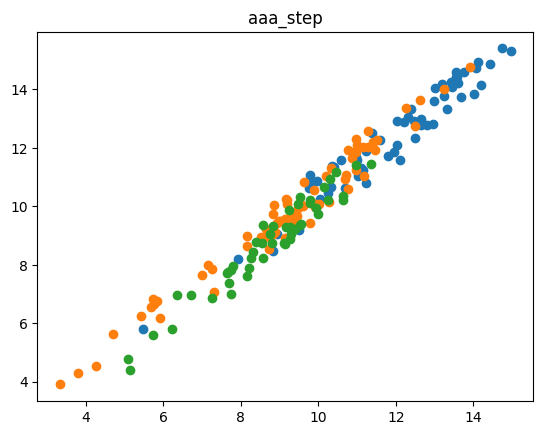

In [118]:
fidelity = calc_fidelity(x_tr,x_tr,pqs_f)
alpha = np.random.rand(len(x_tr),2)
def calc_y(fidelity:NDArray[np.float_],alpha:NDArray[np.float_]) -> NDArray[np.float_]:
    fidelity = (fidelity + fidelity.T)/2.
    return fidelity @ alpha
    y_list = []
    for i in range(len(fidelity)):
        conditional_fidelity = fidelity[i][:,np.newaxis]
        conditional_fidelity = np.append(conditional_fidelity,conditional_fidelity,axis=1)
        y_i = alpha.T @ conditional_fidelity
        y = y_i[:,0]
        y_list.append(y)
    return np.array(y_list)

y = calc_y(fidelity,alpha)
print(y)
q_prob = tsne.calc_probabilities_q(y)

label = y_label
import matplotlib.pyplot as plt
for i in np.unique(label):
    plt.scatter(y[:,0][label == i],y[:,1][label == i])
    tmp_name = "aaa"+"_step"
    plt.title(tmp_name)
plt.show()

In [112]:
def calc_loss(p_prob,q_prob):
    EPS_abs = 1e-12
    p_prob = np.maximum(p_prob,EPS_abs)
    q_prob = np.maximum(q_prob,EPS_abs)
    # ! なんか動かなかったからlog外しました
    loss = tsne.kldiv(p_prob,q_prob)
    return loss

print(calc_loss(p_prob,q_prob))

1.213803685594331


In [113]:
def calc_grad_C_y(p_prob,q_prob,y):
    # dC/dy_i = 4*sum_j{(p_ij-q_ij)(y_i-y_j)/(1+||y_i-y_j||^2)}
    grad_list = []
    for i in range(len(y)):
        tmp_pq = (p_prob-q_prob)[i,:]
        tmp_y_norm = np.linalg.norm(y[i]-y,axis=1)**2
        tmp_y_norm = 1/(1+tmp_y_norm)
        coef = tmp_pq * tmp_y_norm
        coef = coef.reshape((-1,1)) 
        tmp_y = coef*(y[i] - y)
        grad = 4*np.sum(tmp_y,axis=0)
        grad_list.append(grad)
        # if i == 0:
        #     print(f"{tmp_pq=}")
        #     print(f"{tmp_y_norm=}")
        #     print(f"{coef=}")
        #     print(f"{y[i]-y=}")
        #     print(f"{grad=}")
    return np.array(grad_list)

# ! こいつが怪しい
def calc_grad_y_alpha(y_index,fidelity):
    grad_list = []
    for i in range(len(fidelity)):
        grad = fidelity[i][y_index]
        grad_list.append(grad)
    return np.array(grad_list)

def calc_grad(p_prob,q_prob,y,fidelity):
    print(f"{p_prob[0]=}")
    print(f"{q_prob[0]=}")
    grad_C_y = calc_grad_C_y(p_prob,q_prob,y)
    grad_list = np.zeros((len(y),2))
    for i in range(len(y)):
        grad_y_alpha_i = calc_grad_y_alpha(i,fidelity)
        grad = grad_C_y[i]*grad_y_alpha_i.reshape((-1,1))
        grad_list += grad
    return grad_list
# print(np.linalg.norm(y[0]-y,axis=1))
print(calc_grad(p_prob,q_prob,y,fidelity))
1

p_prob[0]=array([0.00000000e+00, 3.23903991e-05, 5.44584634e-05, 5.88481737e-05,
       1.39092462e-05, 5.99018115e-05, 1.77775115e-04, 1.96884709e-04,
       5.57166357e-05, 1.54124700e-04, 6.36791249e-05, 2.01571103e-05,
       2.18234776e-05, 3.11438412e-05, 4.37671230e-05, 3.03744364e-05,
       5.08589914e-05, 3.38749728e-05, 2.12328346e-05, 9.45889569e-05,
       9.25752879e-04, 2.63383792e-05, 2.13904005e-04, 2.32618635e-05,
       4.89713837e-05, 1.02885498e-05, 2.80769080e-05, 8.33679466e-06,
       7.34190494e-05, 1.62239429e-04, 1.61577740e-05, 4.06850900e-05,
       2.42011048e-05, 3.06285070e-05, 2.68751373e-05, 7.74755300e-05,
       1.74241277e-05, 6.13329697e-06, 7.21537905e-06, 1.28398006e-04,
       2.72896205e-04, 5.94317902e-06, 1.14624480e-04, 6.98768088e-06,
       7.38090545e-05, 3.18920326e-05, 1.12073093e-04, 1.13907556e-04,
       6.28740528e-05, 7.43939828e-05, 1.74135475e-05, 7.67434099e-05,
       7.49592067e-05, 4.44222423e-05, 1.77655526e-04, 9.24349714e-

1

In [114]:
def cost_f(alpha:NDArray[np.float_],p_prob:NDArray[np.float_]):
    y = calc_y(fidelity,alpha.reshape(len(alpha)//2,2))
    q_prob = tsne.calc_probabilities_q(y)
    loss = calc_loss(p_prob,q_prob)
    print(f"{loss=}")
    return loss

def grad_f(alpha:NDArray[np.float_],p_prob:NDArray[np.float_],fidelity:NDArray[np.float_]):
    y = calc_y(fidelity,alpha.reshape(len(alpha)//2,2))
    q_prob = tsne.calc_probabilities_q(y)
    grad = calc_grad(p_prob,q_prob,y,fidelity).flatten()
    return grad*2.2

# grad_f = partial(grad_f,fidelity=fidelity)
from scipy.optimize import minimize
# result = minimize(cost_f,alpha.flatten(),args=(p_prob,),options={"maxiter":1000},method="BFGS",jac=grad_f)
# print(result)
from quri_parts.algo.optimizer import Adam,OptimizerStatus
optimizer = Adam(ftol=1e-12)
optimizer_state = optimizer.get_init_state(alpha.flatten())
cost_func = partial(cost_f,p_prob=p_prob)
grad_func = partial(grad_f,p_prob=p_prob,fidelity=fidelity)

result = minimize(cost_func,alpha.flatten(),options={"maxiter":3000},method="COBYLA",)
print(result)
alpha = result.x

# c = 0
# while 10000 > c:
#     optimizer_state = optimizer.step(optimizer_state,cost_func,grad_func)
#     print(f"{optimizer_state.cost=}")
#     if optimizer_state.status == OptimizerStatus.CONVERGED:
#         break
#     if optimizer_state.status == OptimizerStatus.FAILED:
#         break
#     print(f"{c=}")
#     c += 1
# print(f"{optimizer_state.cost=}")
# alpha = optimizer_state.params

loss=1.213803685594331
loss=1.2018738510170042
loss=1.2026197589650538
loss=1.1924154031370013
loss=1.1928394013117503
loss=1.1816870934703554
loss=1.1838686938927006
loss=1.1711584767967256
loss=1.172999947115301
loss=1.1678157212047058
loss=1.1692245910707382
loss=1.1579529751085125
loss=1.1608337273218683
loss=1.149486160512451
loss=1.1520312681117146
loss=1.1432096174586892
loss=1.1456424241465533
loss=1.134026770481781
loss=1.137530547247785
loss=1.125639643518086
loss=1.1285153053155097
loss=1.1167121600032277
loss=1.1197067741040834
loss=1.110170933185867
loss=1.1132646974110934
loss=1.1044670209099572
loss=1.1075968932995686
loss=1.0989255580026362
loss=1.1004702532543933
loss=1.0923067460248712
loss=1.0942680945121437
loss=1.0868811144507944
loss=1.0882782779460736
loss=1.0820652171367886
loss=1.0848713728365156
loss=1.0788267911494094
loss=1.080631315135047
loss=1.0744671729509299
loss=1.076170096125903
loss=1.0686529391561677
loss=1.0707725277662798
loss=1.0626913048551998
l

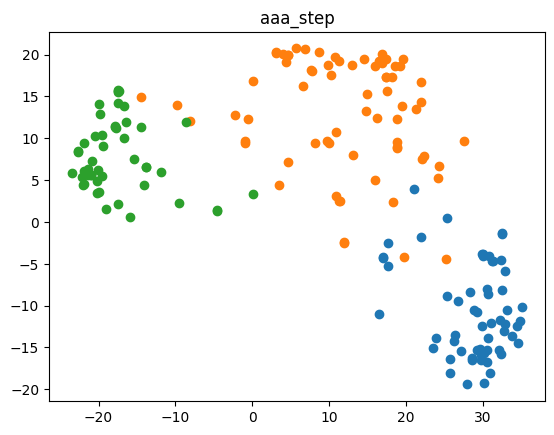

In [115]:
label = y_label
import matplotlib.pyplot as plt
y = calc_y(fidelity,alpha.reshape(len(alpha)//2,2))
for i in np.unique(label):
    plt.scatter(y[:,0][label == i],y[:,1][label == i])
    tmp_name = "aaa"+"_step"
    plt.title(tmp_name)
plt.show()

In [116]:
def calc_grad_C_y(p_prob,q_prob,y):
    # dC/dy_i = 2*sum_j{(p_ij-q_ij+p_ji-q_ji)(y_i-y_j)}
    tmp_pq = p_prob-q_prob + p_prob.T - q_prob.T
    grad_list = []
    for i in range(len(y)):
        tmp_pq = p_prob[i,:] - q_prob[i,:] + p_prob[:,i].T - q_prob[:,i].T
        tmp_y = y[i] - y
        grad = 2*tmp_pq@tmp_y
        grad_list.append(grad)
    return np.array(grad_list)

def calc_grad_y_alpha(y_index,fidelity):
    grad_list = []
    for i in range(len(fidelity)):
        grad = fidelity[i][y_index]
        grad_list.append(grad)
    return np.array(grad_list)

def calc_grad(p_prob,q_prob,y,fidelity):
    grad_C_y = calc_grad_C_y(p_prob,q_prob,y)
    grad_list = np.zeros((len(y),2))
    for i in range(len(y)):
        grad_y_alpha_i = calc_grad_y_alpha(i,fidelity)
        grad = grad_C_y[i]*grad_y_alpha_i.reshape((-1,1))
        grad_list += grad
    return grad_list



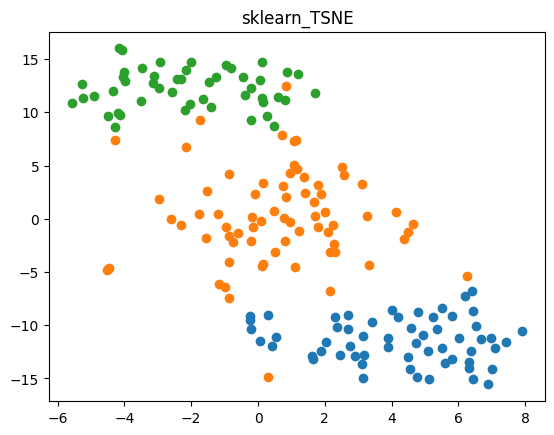

In [117]:
from sklearn.manifold import TSNE
y = TSNE(n_components=2,perplexity=30).fit_transform(x_tr)
label = y_label
for i in np.unique(label):
    plt.scatter(y[:,0][label == i],y[:,1][label == i])
    tmp_name = "sklearn_TSNE"
    plt.title(tmp_name)
plt.show()